In [1263]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [1264]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_100_1_1e-1_wgan' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_100_1_1e-1_wgan_reals.npy']

In [1265]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [1266]:
reals.shape

(100, 1, 32, 32)

In [1267]:
reals.mean(1).shape

(100, 32, 32)

# Error of ASPA $i$

In [1268]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.00000,1.0000
mean,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403
25%,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403
50%,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403
75%,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403
max,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403


In [1269]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-0.924465,-3.061524,-8.066015,-5.986753,3.135909e+27,5.601126e+07,1343.593851,-0.26719,9.8403


In [1270]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [1271]:
reals.shape

(100, 1, 32, 32)

In [1272]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(100, 1, 32, 32)

In [1273]:
reals.shape

(100, 1, 32, 32)

## Spectrum plot

In [1274]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [1275]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

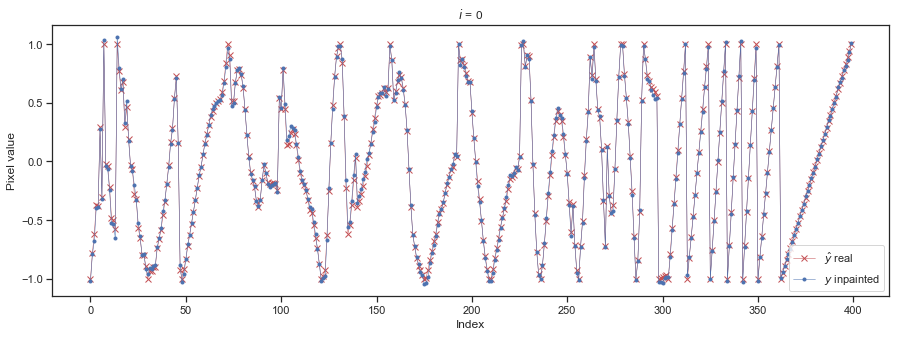

In [1276]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0, 0.5, '$y$-$\\hat{y}$')

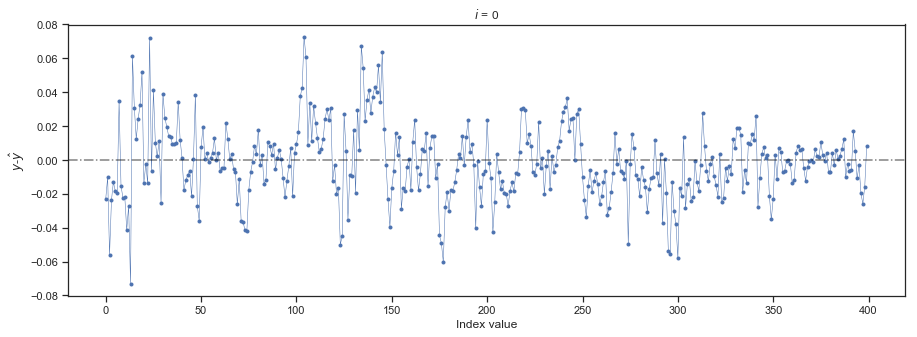

In [1277]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:370: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:371: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


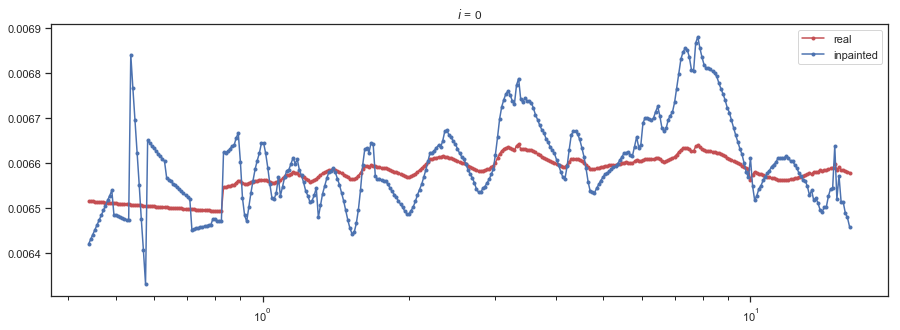

In [1278]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

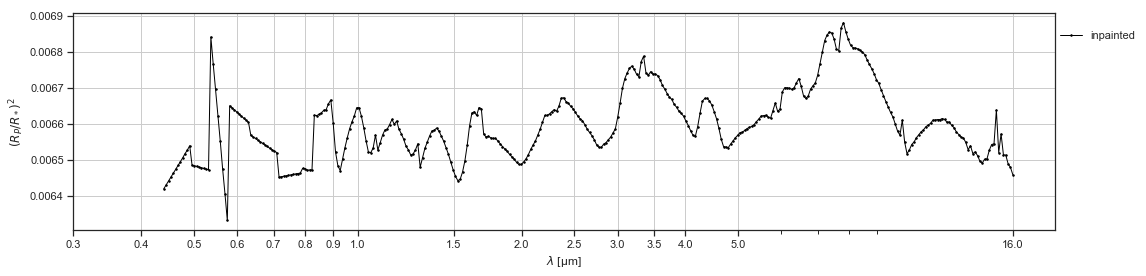

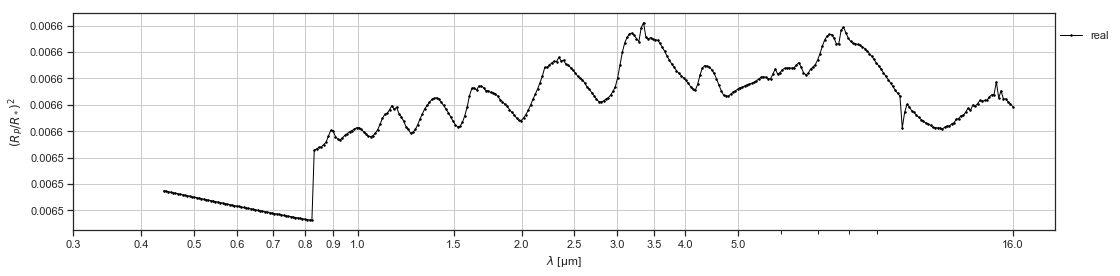

In [1279]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [1280]:
reals.shape

(100, 1, 32, 32)

In [1281]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [1282]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [1283]:
contextuals.shape

(100,)

In [1284]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [1285]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-1.914002,-0.227103,-0.691416,0.192590,0.297421,-0.450365,-3.559215
std,11.239696,13.312873,53.838669,10.691369,31.483784,0.994929,31.071738
min,-55.879405,-55.253251,-78.949636,-36.978469,-53.875111,-4.356858,-47.494301
25%,-4.600401,-5.614510,-30.647233,-4.277287,-22.961056,-0.911445,-26.427227
50%,-1.306247,-0.790617,-7.254497,-1.115244,-2.229378,-0.392412,-8.517969
75%,0.865414,2.351760,7.111549,5.068660,11.182389,0.190913,12.618586
max,30.037720,58.740277,220.948384,35.057686,118.189625,2.178906,96.012259


In [1286]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,-7.553452,-8.154293,215.626667,-7.102113,3.263614,0.147434,9.930407
1,-17.817342,-11.570852,-74.593773,-15.324550,13.539624,-1.186700,88.192505
2,-0.121731,-0.809373,-22.445562,-2.878148,-22.278280,0.243217,-23.170196
3,2.604123,26.696664,215.444855,4.705656,-50.889345,-0.036686,1.894778
4,20.803213,-7.042157,-13.667999,5.016192,-23.411097,-0.557602,-40.909576
5,0.163634,4.688035,12.324469,-15.589893,11.852974,-1.041702,25.150966
6,9.966812,1.540388,3.078712,-6.046973,-2.886634,0.679477,-34.103868
7,0.578671,-0.257259,-33.212807,3.952080,35.730274,0.700589,-8.859417
8,-5.059872,-7.847610,-35.605660,-6.579767,-40.696819,-2.475386,-17.629704
9,-3.513069,-4.515461,-50.975349,0.548619,-26.185052,-4.303331,-1.162305


In [1287]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
26,8.99466,-5.548671,0.047648,7.812491,4.515483,-0.892664,61.225544


In [1288]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [1289]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-4.608889,-4.523333,-4.577778,-5.005556,2.654669e+27,8.083265e+07,1508.888889,-4.523710,-4.504407,-4.238357,...,1389.739414,-1.914002,-0.227103,-0.691416,0.192590,0.297421,-0.450365,-3.559215,-0.217339,11.127132
std,2.242582,2.239679,2.129315,2.263884,6.819912e+26,1.563348e+07,322.564551,2.257930,2.344110,2.356051,...,317.286118,11.239696,13.312873,53.838669,10.691369,31.483784,0.994929,31.071738,0.038883,3.240070
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-7.907094,-8.440086,-8.343229,...,961.625814,-55.879405,-55.253251,-78.949636,-36.978469,-53.875111,-4.356858,-47.494301,-0.311586,7.585836
25%,-6.444445,-6.444445,-6.444445,-7.222222,2.277600e+27,6.680384e+07,1222.222209,-6.440387,-6.312191,-6.072885,...,1108.123556,-4.600401,-5.614510,-30.647233,-4.277287,-22.961056,-0.911445,-26.427227,-0.241797,9.186614
50%,-4.888889,-4.888889,-4.500000,-5.666667,2.783733e+27,7.767889e+07,1555.555556,-4.770172,-4.244771,-3.819849,...,1342.183582,-1.306247,-0.790617,-7.254497,-1.115244,-2.229378,-0.392412,-8.517969,-0.224216,10.358865
75%,-2.555555,-2.555555,-2.555555,-3.333333,3.100067e+27,9.399146e+07,1777.777791,-2.313624,-2.510469,-2.333492,...,1645.192385,0.865414,2.351760,7.111549,5.068660,11.182389,0.190913,12.618586,-0.193097,12.395929
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-0.924465,-0.904525,-0.878502,...,2010.872006,30.037720,58.740277,220.948384,35.057686,118.189625,2.178906,96.012259,-0.124643,31.705269


In [1290]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-1.000000,-3.333333,-2.555555,-6.444445,3.036800e+27,5.592880e+07,1222.222209,-0.924465,-3.061524,-8.066015,...,1343.593851,-7.553452,-8.154293,215.626667,-7.102113,3.263614,0.147434,9.930407,-0.267190,9.840300
1,-3.333333,-4.888889,-4.111111,-2.555555,2.530667e+27,9.942898e+07,1000.000000,-2.739422,-4.323203,-1.044478,...,1881.925046,-17.817342,-11.570852,-74.593773,-15.324550,13.539624,-1.186700,88.192505,-0.228949,16.679495
2,-7.222222,-5.666667,-1.777778,-5.666667,2.783733e+27,7.224137e+07,1444.444444,-7.213431,-5.620802,-1.378746,...,1109.763831,-0.121731,-0.809373,-22.445562,-2.878148,-22.278280,0.243217,-23.170196,-0.171301,13.042578
3,-4.111111,-1.000000,-2.555555,-4.111111,3.542933e+27,6.680384e+07,1333.333328,-4.218170,-1.266967,-8.061368,...,1358.597040,2.604123,26.696664,215.444855,4.705656,-50.889345,-0.036686,1.894778,-0.256220,12.405085
4,-1.000000,-4.111111,-3.333333,-2.555555,2.277600e+27,7.767889e+07,2000.000000,-1.208032,-3.821600,-2.877733,...,1181.808472,20.803213,-7.042157,-13.667999,5.016192,-23.411097,-0.557602,-40.909576,-0.207637,8.951052
5,-5.666667,-8.000000,-4.888889,-1.000000,2.783733e+27,1.048665e+08,1333.333328,-5.675939,-8.375043,-5.491419,...,1668.679535,0.163634,4.688035,12.324469,-15.589893,11.852974,-1.041702,25.150966,-0.224709,8.109283
6,-6.444445,-2.555555,-8.000000,-3.333333,2.783733e+27,1.048665e+08,1555.555556,-7.086750,-2.594921,-8.246297,...,1025.050938,9.966812,1.540388,3.078712,-6.046973,-2.886634,0.679477,-34.103868,-0.199307,8.417005
7,-4.111111,-5.666667,-7.222222,-6.444445,2.277600e+27,1.048665e+08,1555.555556,-4.134901,-5.652089,-4.823520,...,1417.742401,0.578671,-0.257259,-33.212807,3.952080,35.730274,0.700589,-8.859417,-0.197977,8.384461
8,-3.333333,-4.111111,-1.777778,-1.777778,2.783733e+27,6.136632e+07,2000.000000,-3.164671,-3.788487,-1.144788,...,1647.405922,-5.059872,-7.847610,-35.605660,-6.579767,-40.696819,-2.475386,-17.629704,-0.197385,10.687872
9,-4.111111,-4.888889,-7.222222,-1.000000,2.277600e+27,6.136632e+07,2000.000000,-3.966685,-4.668133,-3.540669,...,1976.753891,-3.513069,-4.515461,-50.975349,0.548619,-26.185052,-4.303331,-1.162305,-0.199943,9.972681


In [1291]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

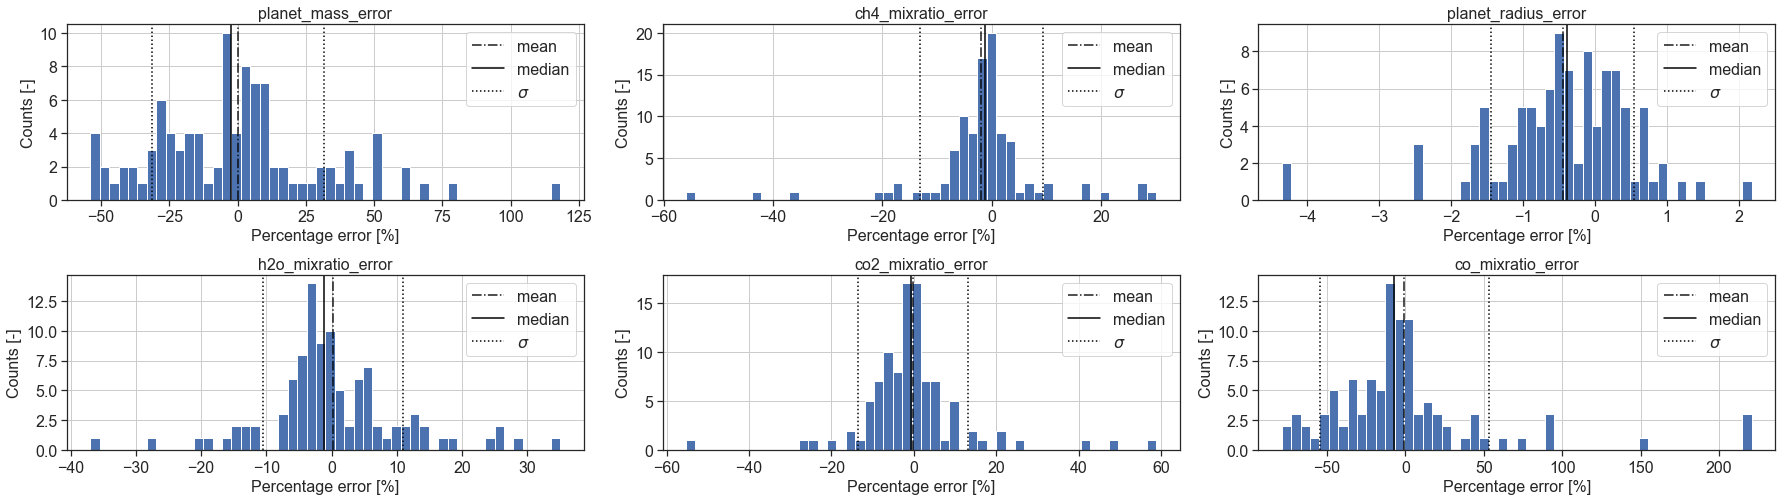

In [1292]:
#params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

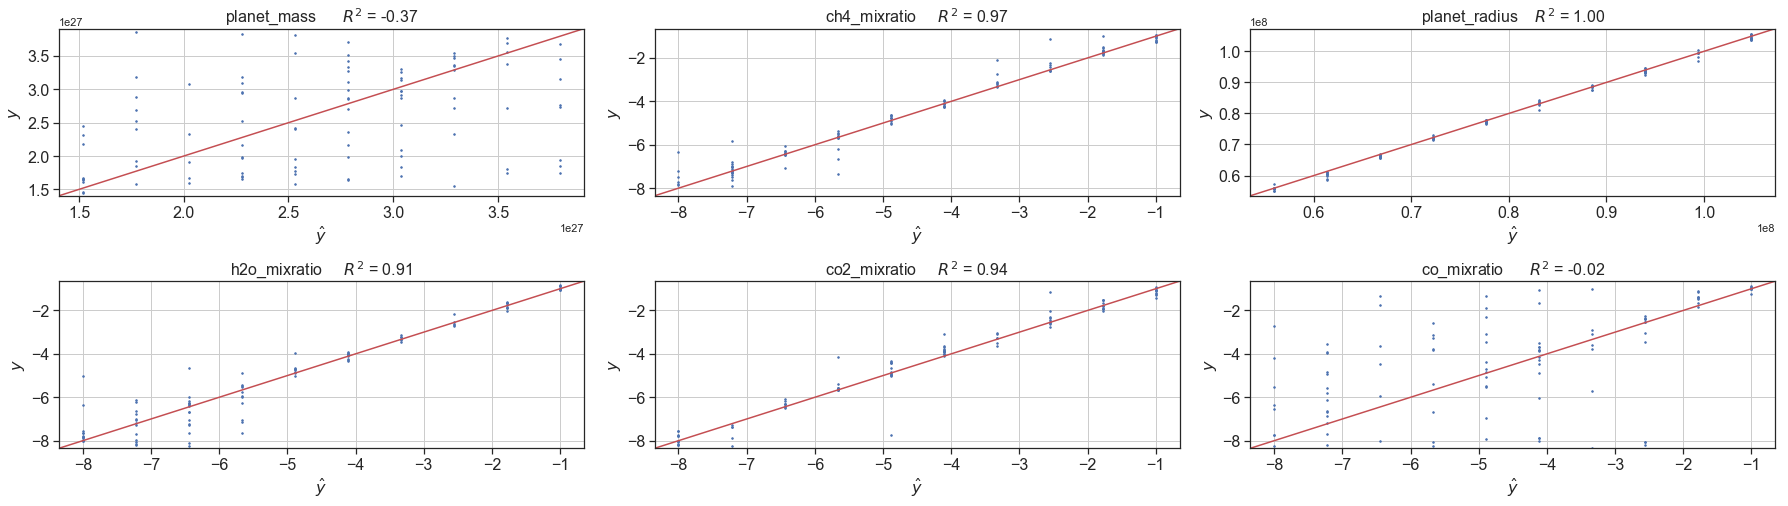

In [1293]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

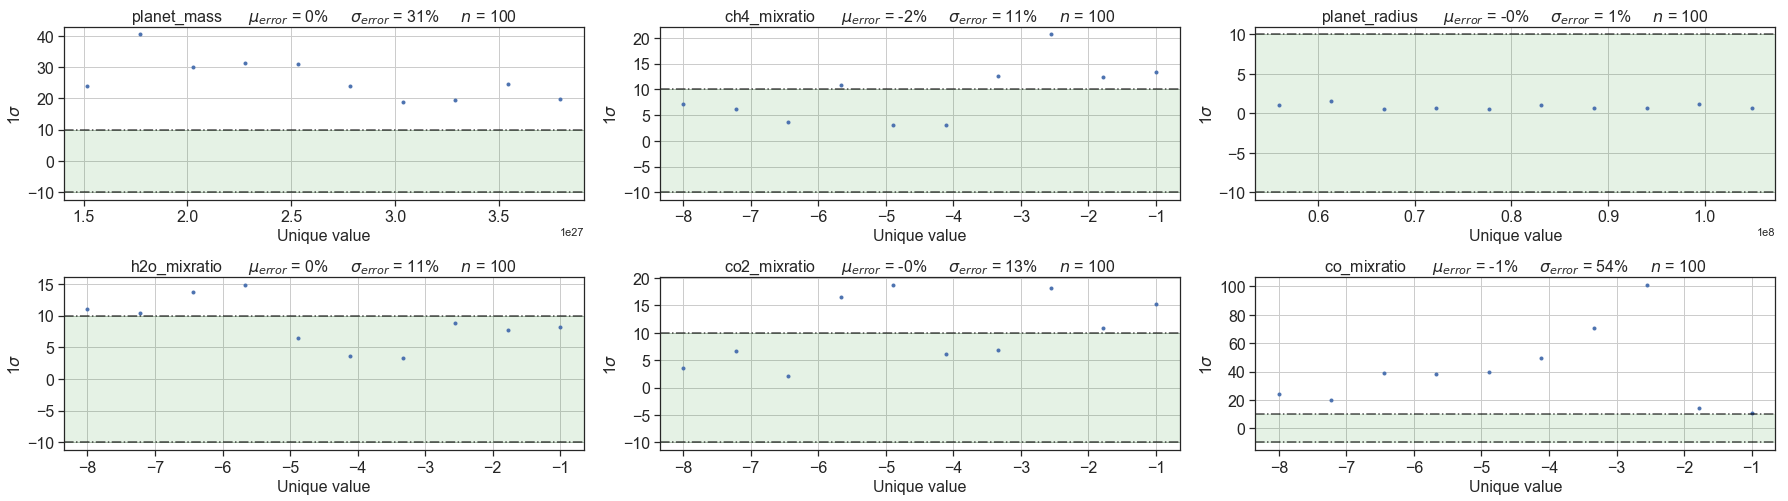

In [1294]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [1295]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [1296]:
uniques

array([-2.55555546, -4.11111111, -1.77777773, -3.3333333 , -4.88888889,
       -8.        , -7.22222227, -5.6666667 , -1.        , -6.44444454])

# Losses

In [1297]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,100.000000,100.000000
mean,-0.217339,11.127132
std,0.038883,3.240070
min,-0.311586,7.585836
25%,-0.241797,9.186614
50%,-0.224216,10.358865
75%,-0.193097,12.395929
max,-0.124643,31.705269


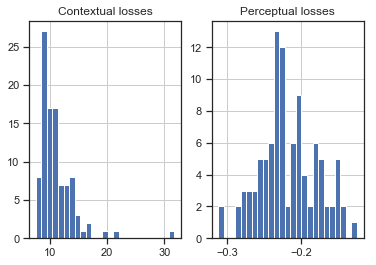

In [1298]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

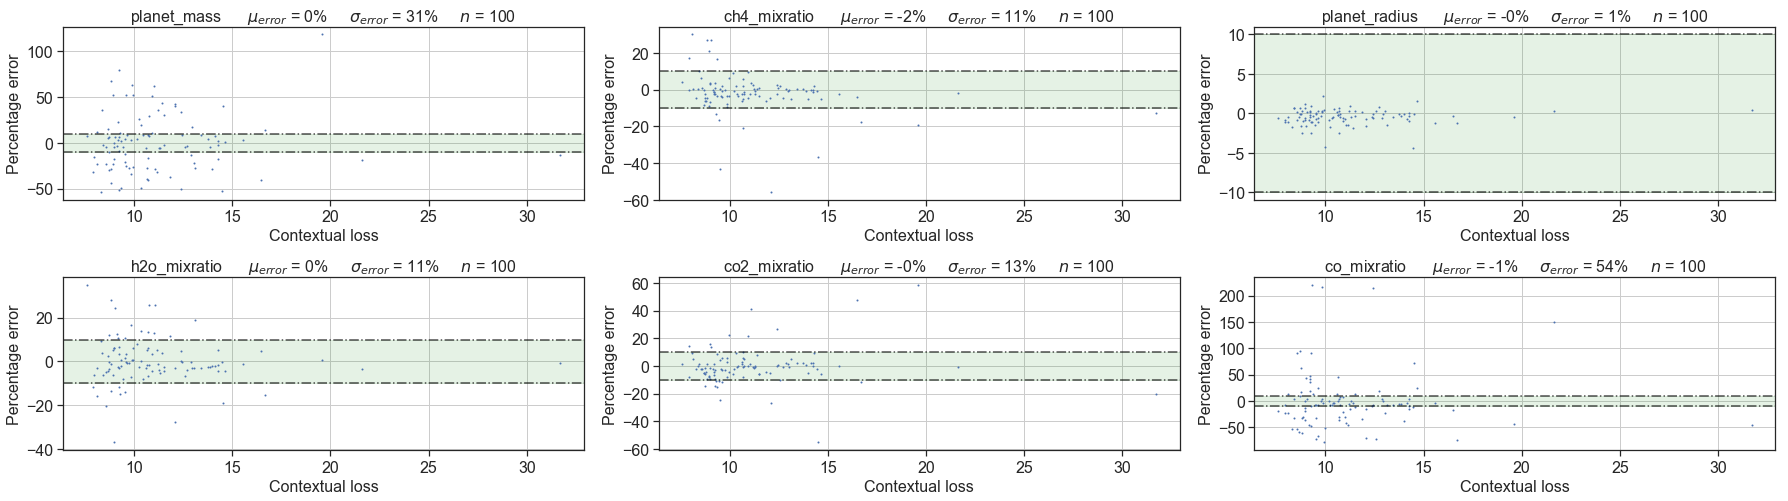

In [1299]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

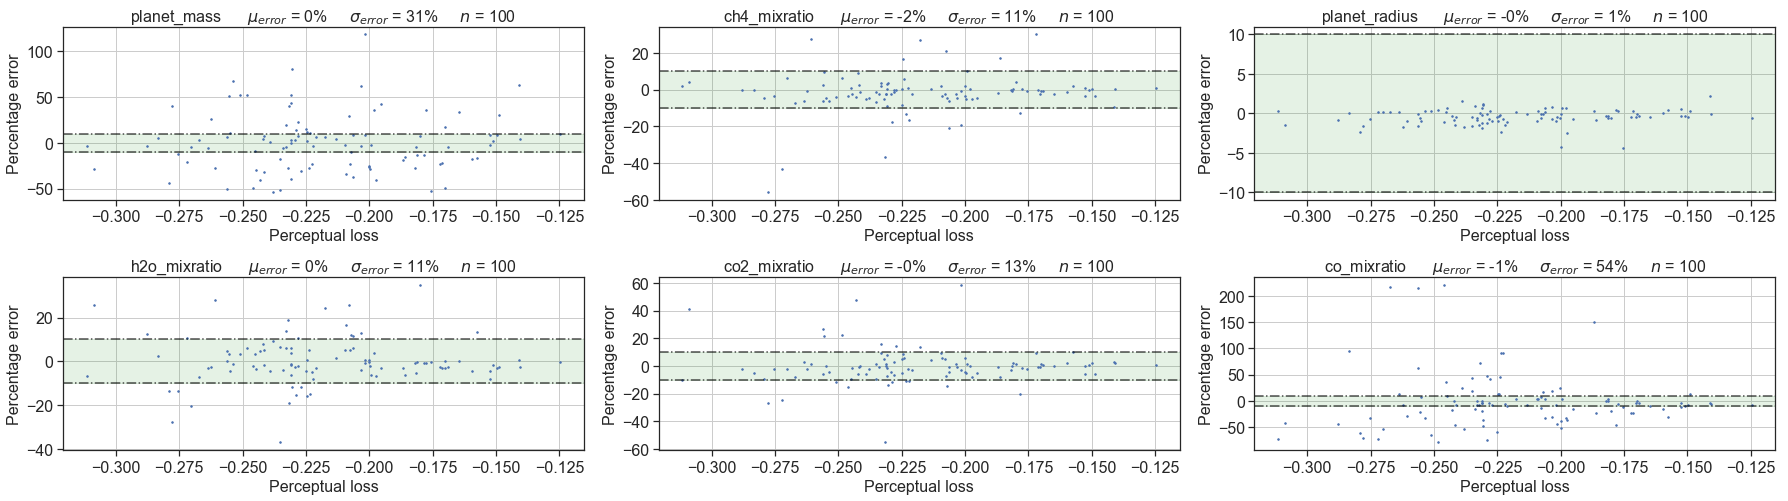

In [1300]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()